In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

In [ ]:

 (X_train, _), (_, _) =tf.keras.datasets.mnist.load_data()
X_train = X_train.astype("float32") / 255.0
X_train = np.expand_dims(X_train, axis=-1)

BUFFER_SIZE = 60000
BATCH_SIZE = 128
LATENT_DIM = 100

dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
def build_generator():
    model = tf.keras.Sequential([
        layers.Input(shape=(LATENT_DIM,)),
        layers.Dense(7 * 7 * 256, use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Reshape((7, 7, 256)),

        layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding="same", use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding="same", use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding="same", use_bias=False, activation="sigmoid")
    ])
    return model

In [ ]:
def build_descriminator():
    model = tf.keras.Sequential([
        layers.Input(shape=(28, 28, 1)),

        layers.Conv2D(64, (5, 5), strides=(2, 2), padding="same"),
        layers.LeakyReLU(),
        layers.Dropout(0.3),

        layers.Conv2D(128, (5, 5), strides=(2, 2), padding="same"),
        layers.LeakyReLU(),
        layers.Dropout(0.3),

        layers.Flatten(),
        layers.Dense(1, activation="sigmoid")
    ])
    return model

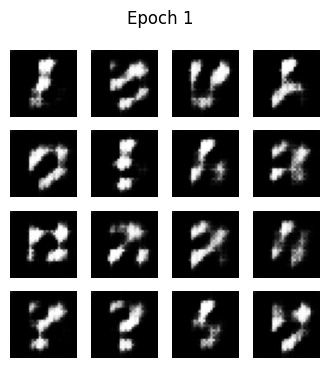

Epoch 1 completed.


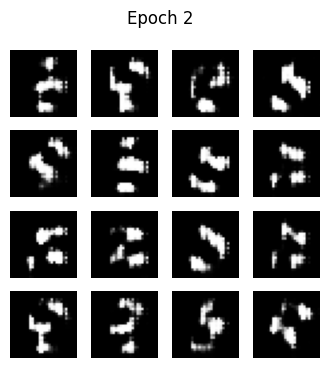

Epoch 2 completed.


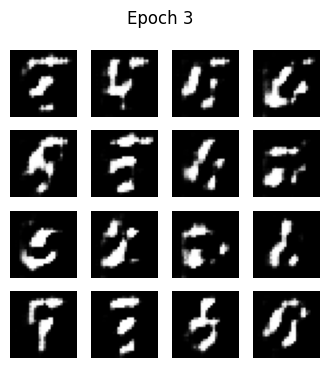

Epoch 3 completed.


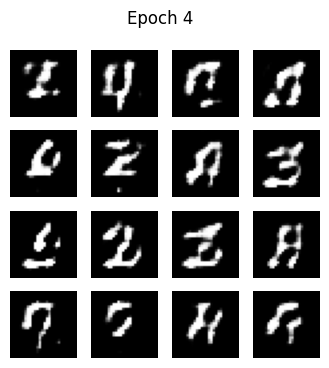

Epoch 4 completed.


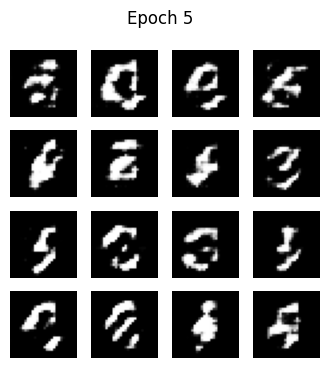

Epoch 5 completed.


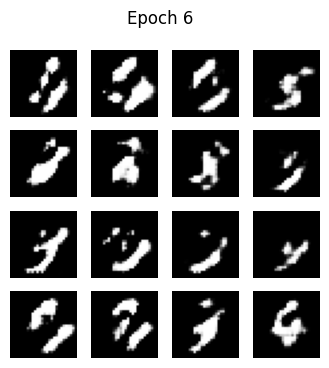

Epoch 6 completed.


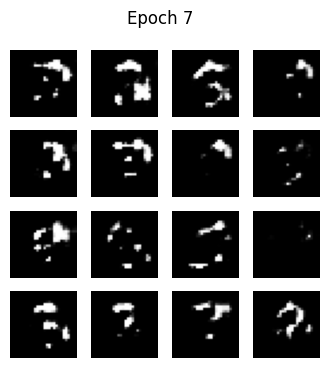

Epoch 7 completed.


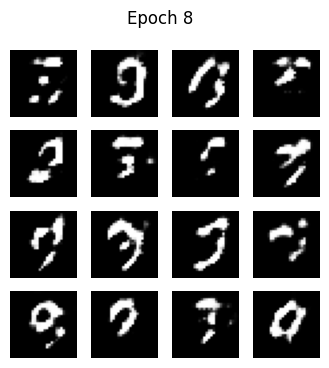

Epoch 8 completed.


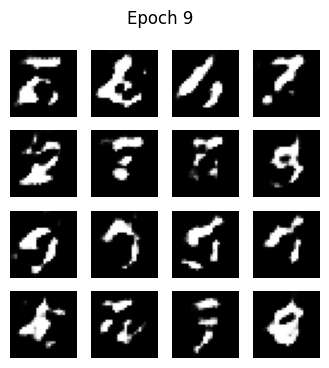

Epoch 9 completed.


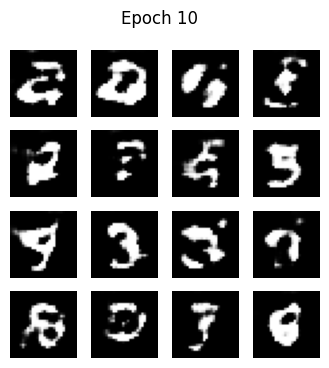

Epoch 10 completed.


In [5]:
generator = build_generator()
discriminator = build_descriminator()

cross_entropy  = tf.keras.losses.BinaryCrossentropy(from_logits=False)
gen_optimizer = tf.keras.optimizers.Adam(1e-4)
disc_optimizer = tf.keras.optimizers.Adam(1e-4)

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

EPOCHS = 10
NOISE_DIM = 100
NUM_EXAMPLES = 16
seed = tf.random.normal([NUM_EXAMPLES, NOISE_DIM])

def train_stop(images):
  noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(noise, training=True)
    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images, training=True)
    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)

  gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  gen_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
  disc_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

def train(dataset, epochs):
  for epoch in range(epochs):
    for image_batch in dataset:
      train_stop(image_batch)

    generate_and_save_images(generator, epoch + 1, seed)
    print(f"Epoch {epoch + 1} completed.")

def generate_and_save_images(model, epoch, test_input):
  predictions = model(test_input, training=False)
  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
    plt.subplot(4, 4, i + 1)
    plt.imshow(predictions[i, :, :, 0], cmap="gray")
    plt.axis("off")

  plt.suptitle(f"Epoch {epoch}")
  plt.show()

train(dataset, EPOCHS)